In [1]:
import sys

sys.path.append("/media/cyprien/Data/Documents/Github/pytorch-forecasting")

import pytorch_lightning as pl
import seaborn as sns
import torch
from data_factory.dataLoader import StockPricesLoader
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import notebook

from pytorch_forecasting import Baseline
from utilities import *

from logging import DEBUG, INFO

from tqdm.notebook import tqdm

%matplotlib inline
sns.set_style("whitegrid")
notebook.tqdm().pandas()

pl.seed_everything(42)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


0it [00:00, ?it/s]

Global seed set to 42


42

In [2]:
config = load_config("../config/config.yml")
assert config['model'] == 'rnn', 'Invalid model in file configuration for this script'
config

{'device': 'cpu',
 'seed': False,
 'model': 'rnn',
 'data': {'save': '../data/save/',
  'suppl': '../data/suppl/',
  'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/',
  'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/',
  'financials': 'financials.csv',
  'stock_prices': 'stock_prices.csv',
  'options': 'options.csv',
  'secondary_stock_price': 'secondary_stock_price.csv',
  'trades': 'trades.csv',
  'cosine': 'cosine_df.csv'},
 'rnn': {'sliding_window': {'max_prediction_length': 10,
   'min_prediction_length': 10,
   'max_encoder_length': 150,
   'min_encoder_length': 150,
   'batch_size': 64},
  'train_val_split': 1,
  'related_stock': 2,
  'manual_scale': True,
  'hidden_size': 20,
  'layers': 3,
  'dropout': 0},
 'temporal_fusion_transformer': {'sliding_window': {'max_prediction_length': 10,
   'min_prediction_length': 10,
   'max_encoder_length': 150,
   'min_encoder_length': 150,
   'batch_size': 64},
  'train_val_split': 1,
  

In [3]:
dl = StockPricesLoader(use_previous_files=True, log_level=DEBUG)

DEBUG:data_factory.dataLoader:Export file ../data/save//export_c6c48d5642cedfa910ae41c1b431de10.p
DEBUG:data_factory.dataLoader:Use config {'device': 'cpu', 'seed': False, 'model': 'rnn', 'data': {'save': '../data/save/', 'suppl': '../data/suppl/', 'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/', 'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/', 'financials': 'financials.csv', 'stock_prices': 'stock_prices.csv', 'options': 'options.csv', 'secondary_stock_price': 'secondary_stock_price.csv', 'trades': 'trades.csv', 'cosine': 'cosine_df.csv'}, 'rnn': {'sliding_window': {'max_prediction_length': 10, 'min_prediction_length': 10, 'max_encoder_length': 150, 'min_encoder_length': 150, 'batch_size': 64}, 'train_val_split': 1, 'related_stock': 2, 'manual_scale': True, 'hidden_size': 20, 'layers': 3, 'dropout': 0}, 'temporal_fusion_transformer': {'sliding_window': {'max_prediction_length': 10, 'min_prediction_length': 10, 'max_encoder_length

## RNN

In [4]:
from pytorch_forecasting.models.rnn import RecurrentNetwork

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

args = dict(
    hidden_size=config['rnn']['hidden_size'],
    rnn_layers=config['rnn']['layers'],
    dropout=config['rnn']['dropout']
)

# configure network and trainer
trainer = pl.Trainer(
    accelerator='gpu',
    gradient_clip_val=0.1,
    # clipping gradients is a hyperparameter and important to prevent divergence
    # of the gradient for recurrent neural networks
    auto_lr_find=True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    weights_summary="top",
)

model = RecurrentNetwork.from_dataset(
    dl.df_train_timeseries,
    **args
)

print(f"Number of parameters in network: {model.size() / 1e3:.1f}k")

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters

Number of parameters in network: 8.7k


#### Train the model

In [5]:
# # fit network

fit = False

if fit:
    trainer.fit(model, train_dataloaders=dl.train_dl, val_dataloaders=dl.test_dl)
else:
    model = RecurrentNetwork.load_from_checkpoint('../scripts/lightning_logs/lightning_logs/version_0/checkpoints/epoch=5-step=280740.ckpt')


/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


## Results

#### Test set

In [6]:
import numpy as np

actuals = torch.cat([y for _, (y, _) in tqdm(iter(dl.test_dl))])
predictions = trainer.predict(model, (X for X, (y, _) in dl.test_dl))

predictions_np = np.array([i.prediction.numpy() for i in predictions]).squeeze(axis=3).reshape(-1, 10)
actuals_np = actuals.cpu().detach().numpy()

  0%|          | 0/2000 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [7]:
# Compute unscaled results

actuals_unscaled = actuals_np.reshape(dl.df_test_ppc.SecuritiesCode.unique().size, -1, 10).copy()
predictions_unscaled = predictions_np.reshape(dl.df_test_ppc.SecuritiesCode.unique().size, -1, 10).copy()

for i, scaler in enumerate(dl.scalers):
    actuals_unscaled[i] = scaler.inverse_transform(actuals_unscaled[i])
for i, scaler in enumerate(dl.scalers):
    predictions_unscaled[i] = scaler.inverse_transform(predictions_unscaled[i])

actuals_unscaled = actuals_unscaled.reshape(-1, 10)
predictions_unscaled = predictions_unscaled.reshape(-1, 10)

In [9]:
# Add predictions in the dataset
import pandas as pd
df_test_res = dl.df_test_ppc.copy()

df_test_res['close_true'] = actuals_np[:, 0].flatten()
df_test_res['close_pred'] = predictions_np[:, 0].flatten()

df_test_res['close_true_unscaled'] = actuals_unscaled[:, 0].flatten()
df_test_res['close_pred_unscaled'] = predictions_unscaled[:, 0].flatten()
df_test_res['close_true_1_unscaled'] = actuals_unscaled[:, 9].flatten()
df_test_res['close_pred_1_unscaled'] = predictions_unscaled[:, 9].flatten()

df_test_res['close_true_unscaled_full'] = pd.Series(list(actuals_unscaled[:, :]))
df_test_res['close_pred_unscaled_full'] = pd.Series(list(predictions_unscaled[:, :]))

df_test_res['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]
df_test_res['target_pred'] = (predictions_np[:, 1] - predictions_np[:, 0]) / predictions_np[:, 0]

df_test_res['target_true_unscaled'] = (actuals_unscaled[:, 1] - actuals_unscaled[:, 0]) / actuals_unscaled[:, 0]
df_test_res['target_pred_unscaled'] = (predictions_unscaled[:, 1] - predictions_unscaled[:, 0]) / predictions_unscaled[:, 0]

df_test_res.loc[:, ['Close', 'close_true_unscaled', 'close_pred_unscaled', 'Target', 'target_true_unscaled', 'target_pred_unscaled']].iloc[:4]


/tmp/ipykernel_40682/3384821310.py:16: RuntimeWarning: invalid value encountered in true_divide
  df_test_res['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]


,Close,close_true_unscaled,close_pred_unscaled,Target,target_true_unscaled,target_pred_unscaled
0,2971.0,3065.0,2970.735840,-0.003263,-0.003263,-0.000176
1,3065.0,3055.0,3064.463623,0.009820,0.009820,-0.000043
2,3055.0,3085.0,3054.865234,0.006483,0.006483,-0.000059
3,3085.0,3105.0,3084.774658,-0.006441,0.000000,-0.000057


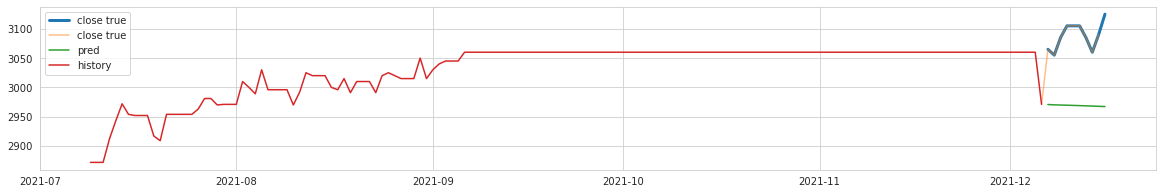

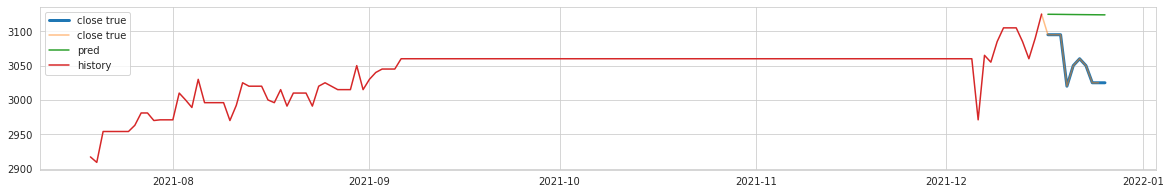

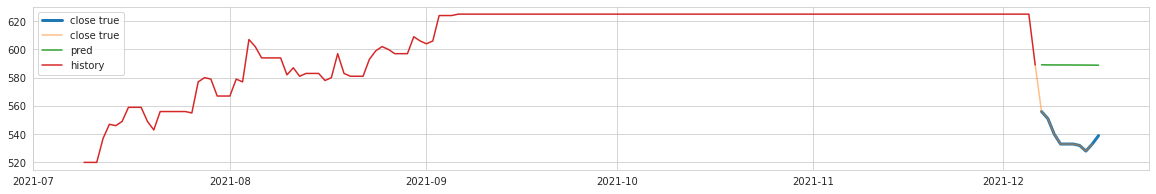

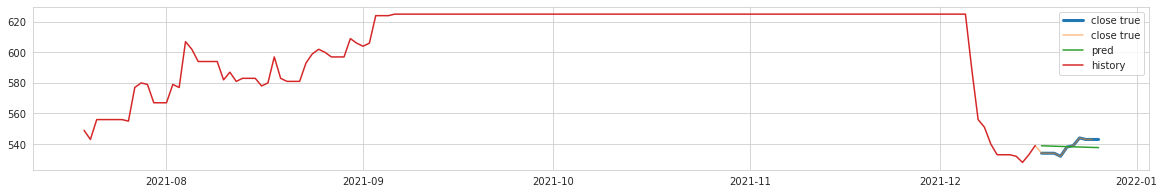

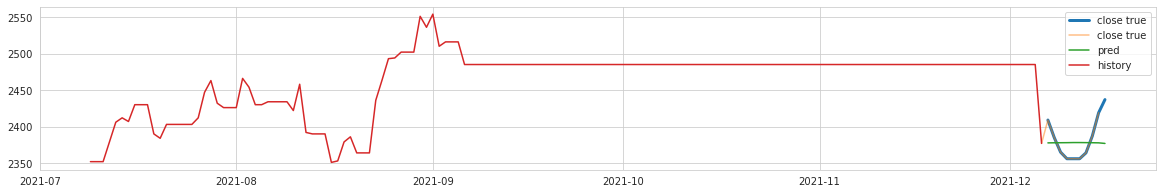

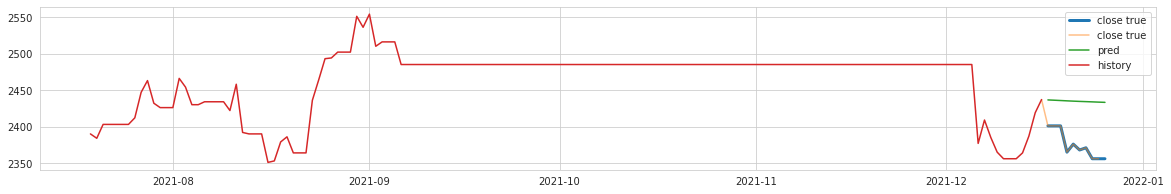

In [24]:
import matplotlib.pyplot as plt

for sc in df_test_res.SecuritiesCode.unique()[:3]:
    for start_point in [0, 10]:

        df = df_test_res[(df_test_res.SecuritiesCode == sc)]
        df = df[(df.Timestamp >= df.Timestamp.min() + start_point) & (df.Timestamp < df.Timestamp.min() + start_point + dl.max_prediction_length)]

        df_full = dl.df_test_ppc_ext[(dl.df_test_ppc_ext.SecuritiesCode == sc)]
        df_full = df_full[(df_full.Timestamp >= df.Timestamp.min() - dl.max_encoder_length) & (df_full.Timestamp <= df.Timestamp.min())]

        figure = plt.figure(figsize=(20, 3))

        plt.plot(df.Date + pd.Timedelta(days=1), df.close_true_unscaled_full.iloc[0], label='close true', figure=figure, linewidth=3)
        # plt.plot(df.Date, df.close_true_unscaled, label='close true 2', figure=figure, alpha=.5)
        # plt.plot(df.Date, df.Close, label='close true 3', figure=figure, alpha=.5)
        plt.plot(df.Date, df.Close, label='close true', figure=figure, alpha=.5)


        plt.plot(df.Date + pd.Timedelta(days=1), df.close_pred_unscaled_full.iloc[0], label='pred', figure=figure)
        plt.plot(df_full.Date, df_full.Close, label='history', figure=figure)


        # df_full = dl.df_test_ppc_ext[(dl.df_test_ppc_ext.SecuritiesCode == sc)]
        # df_full = df_full[(df_full.Timestamp >= df.Timestamp.min()) & (df_full.Timestamp <= df.Timestamp.min() + dl.max_prediction_length)]
        # plt.plot(df_full.Date, df_full.Close, label='close true 3', figure=figure, alpha=.5)


        plt.legend()
        plt.show()

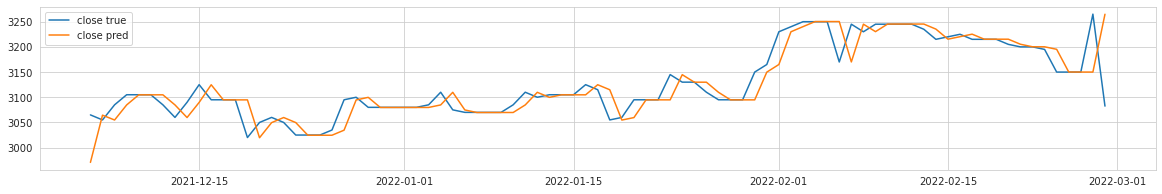

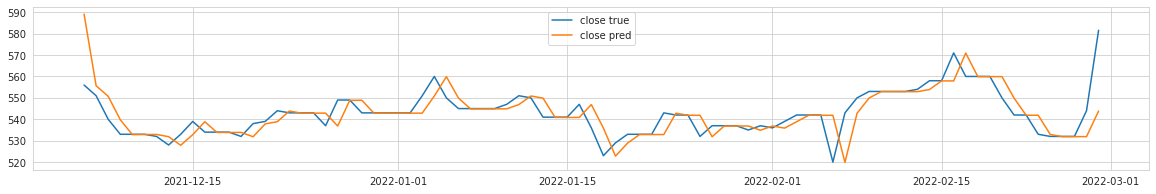

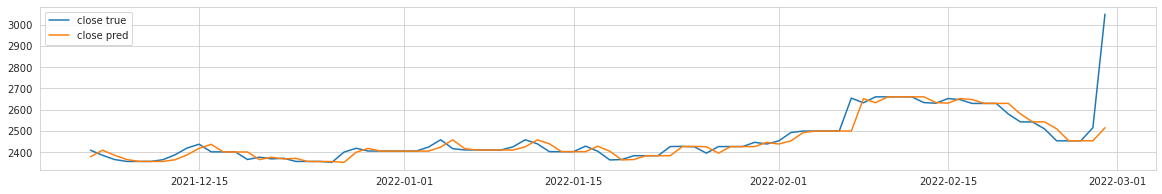

In [25]:
import matplotlib.pyplot as plt

for sc in df_test_res.SecuritiesCode.unique()[:3]:
    df_full = df_test_res[df_test_res.SecuritiesCode == sc]
    figure = plt.figure(figsize=(20, 3))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df_full.Date, df_full.close_true_unscaled, label='close true', figure=figure)
    plt.plot(df_full.Date, df_full.close_pred_unscaled, label='close pred', figure=figure)

    plt.legend()
    plt.show()

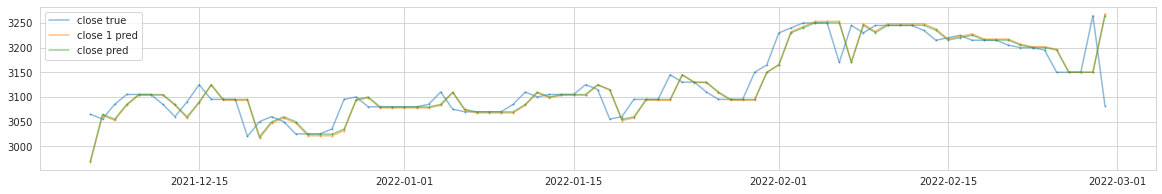

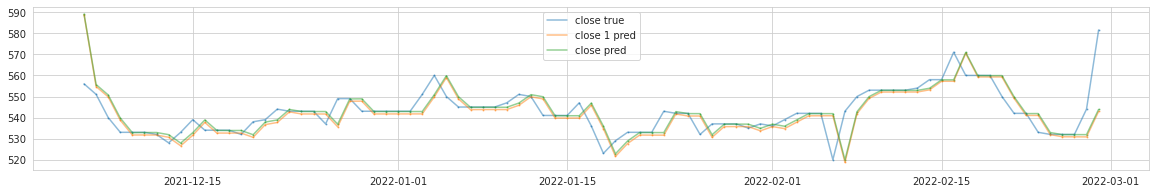

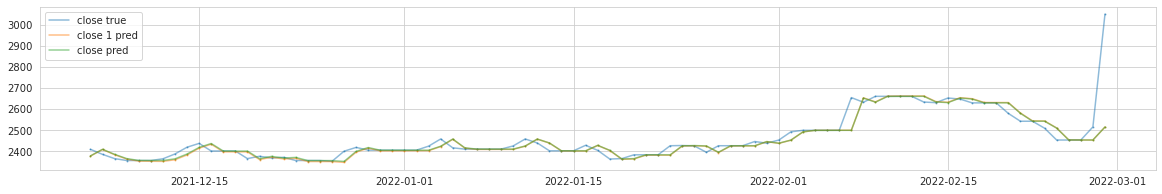

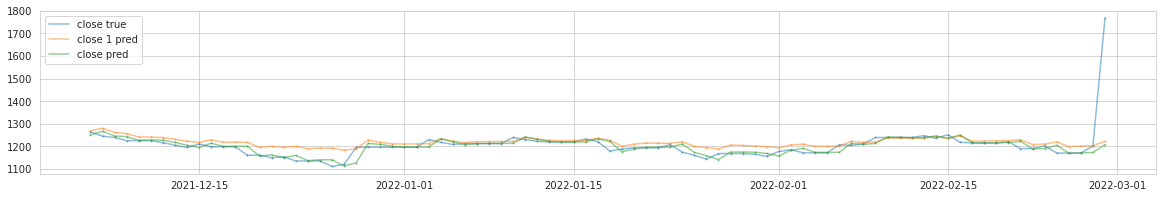

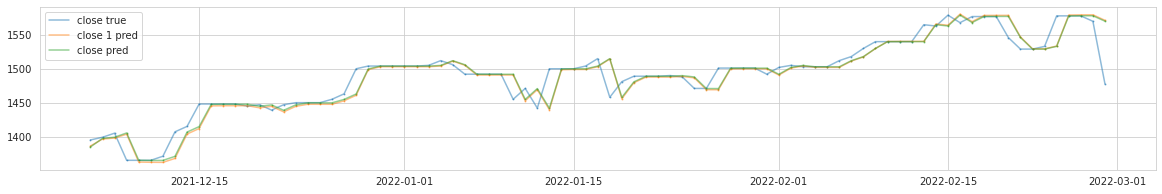

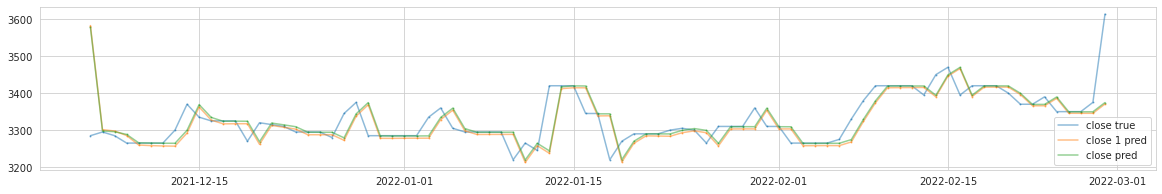

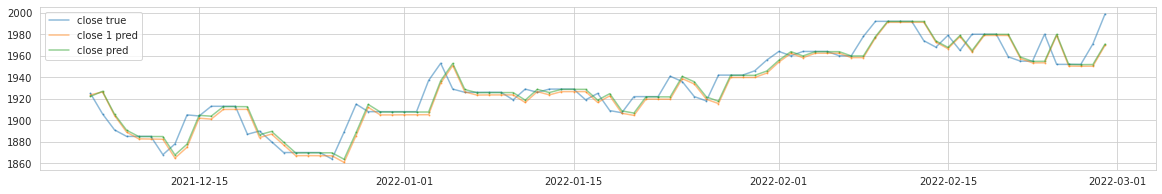

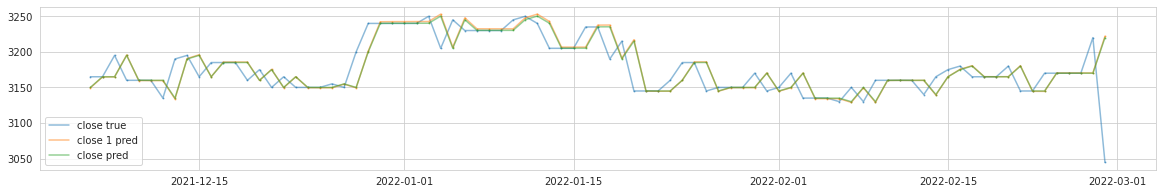

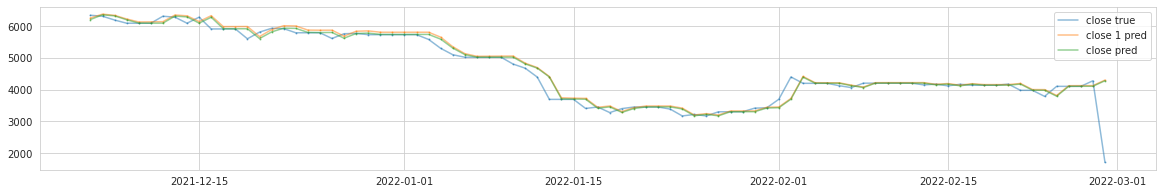

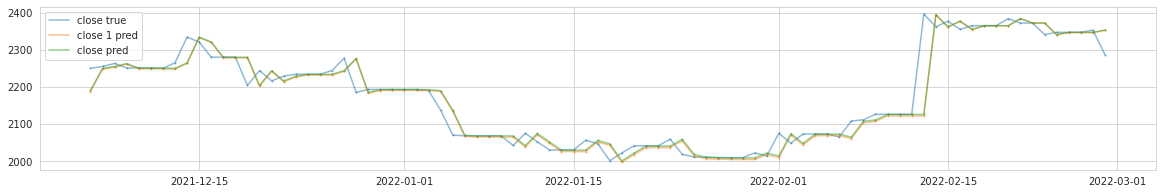

In [26]:
import matplotlib.pyplot as plt

for sc in df_test_res.SecuritiesCode.unique()[:10]:
    df_full = df_test_res[df_test_res.SecuritiesCode == sc]
    figure = plt.figure(figsize=(20, 3))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df_full.Date, df_full.close_true_unscaled, label='close true', figure=figure, alpha=.5)
    plt.plot(df_full.Date, df_full.close_pred_1_unscaled, label='close 1 pred', figure=figure, alpha=.5)
    plt.plot(df_full.Date, df_full.close_pred_unscaled, label='close pred', figure=figure, alpha=.5)

    plt.scatter(df_full.Date, df_full.close_true_unscaled, figure=figure, alpha=.5, s=1)
    plt.scatter(df_full.Date, df_full.close_pred_1_unscaled, figure=figure, alpha=.5, s=1)
    plt.scatter(df_full.Date, df_full.close_pred_unscaled, figure=figure, alpha=.5, s=1)

    plt.legend()
    plt.show()

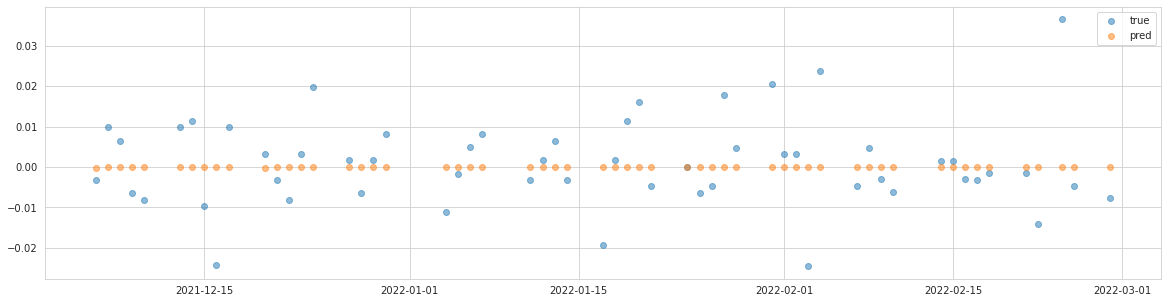

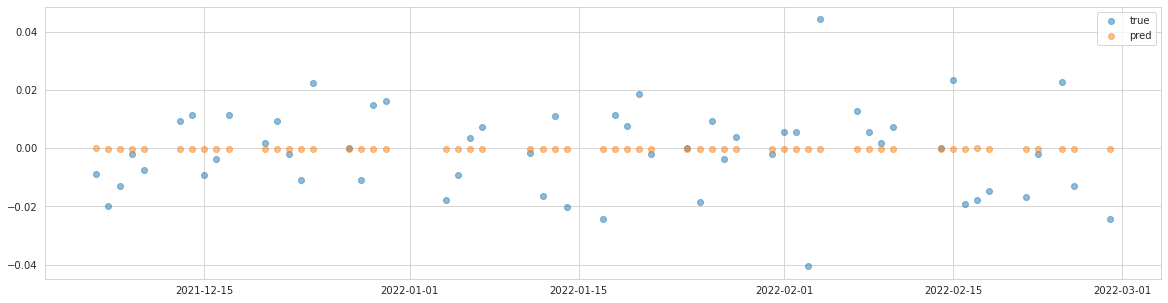

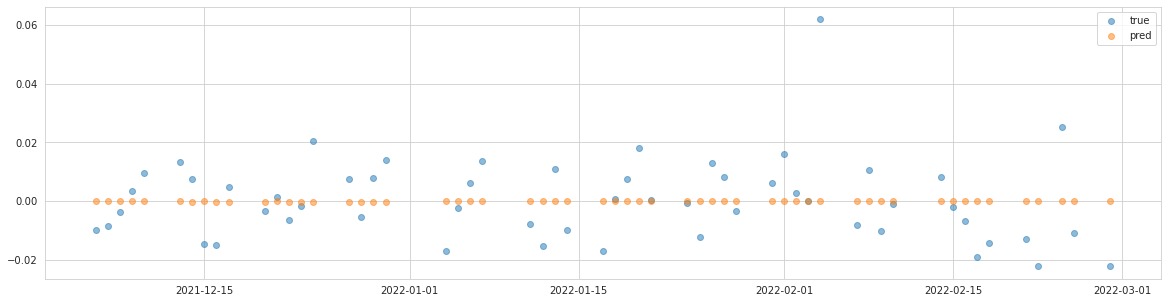

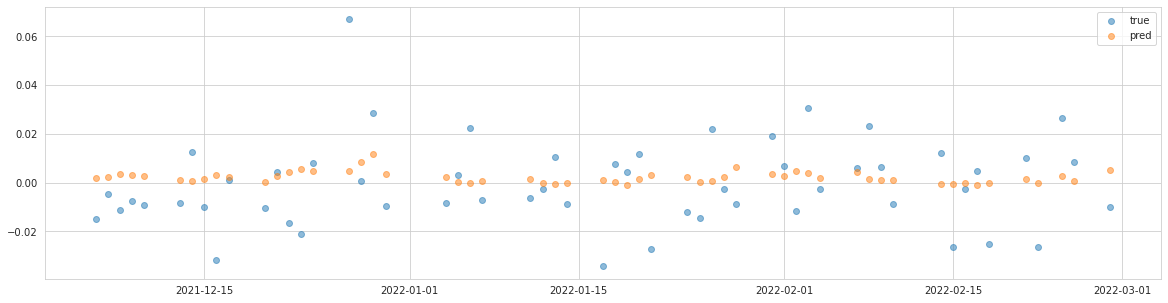

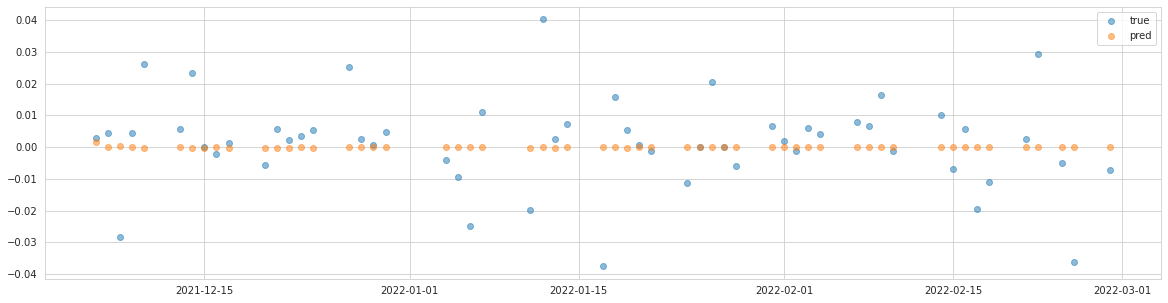

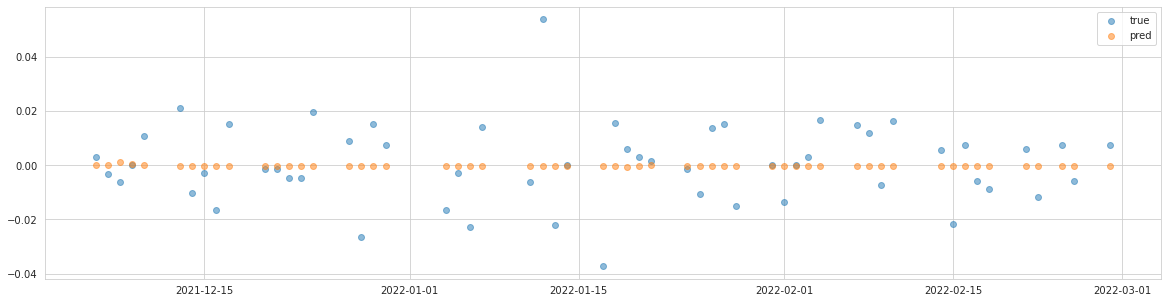

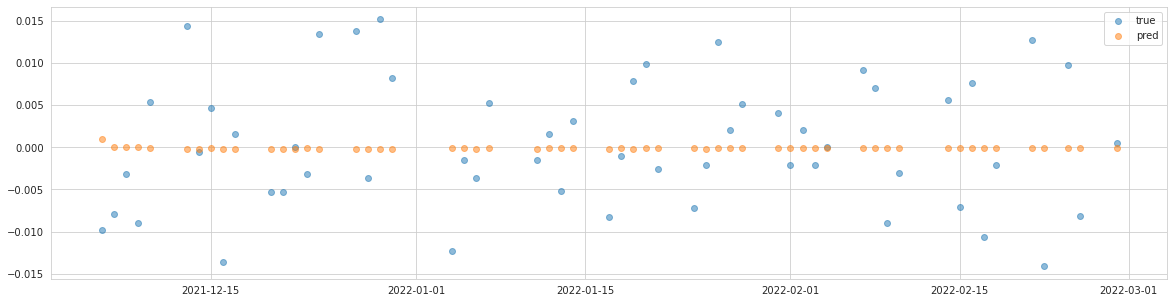

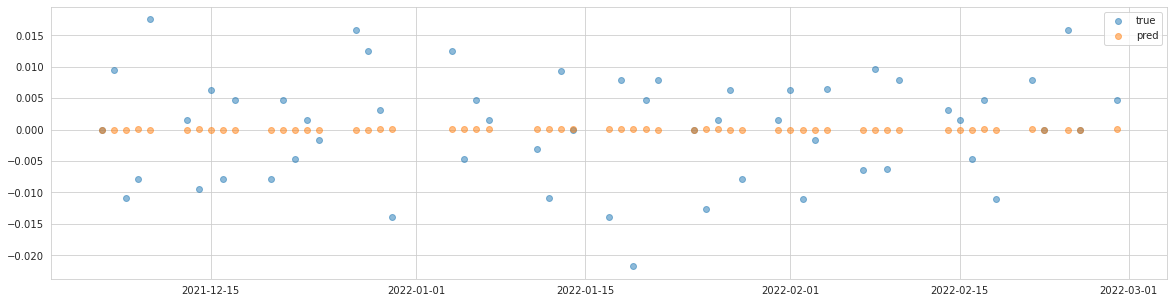

In [27]:
import matplotlib.pyplot as plt

recreated_target_is_valid = df_test_res.groupby('SecuritiesCode').apply(lambda x: (x.authentic == True).shift(-2).fillna(value=False) & (x.authentic == True).shift(-1).fillna(value=False) & (x.authentic == True)).reset_index(drop=True)
evaluated_target = (df_test_res.authentic == True)

for sc in df_test_res.SecuritiesCode.unique()[:8]:
    df_full = df_test_res[(df_test_res.SecuritiesCode == sc) & evaluated_target]
    figure = plt.figure(figsize=(20, 5))
    plt.scatter(df_full.Date, df_full.Target, label='true', figure=figure, alpha=.5)
    # plt.scatter(df.Date, df.target_true_unscaled, label='true2', figure=figure, alpha=.5)
    plt.scatter(df_full.Date, df_full.target_pred_unscaled, label='pred', figure=figure, alpha=.5)
    plt.legend()
    plt.show()

In [28]:
from utilities.evaluation import calc_spread_return_sharpe

In [29]:
df_test_res['Rank'] = (df_test_res.groupby("Date")["target_true_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(df_test_res)

0.9333851997952436

In [30]:
df_test_res['Rank'] = (df_test_res.groupby("Date")["target_pred_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(df_test_res)

-0.24593768402118923

 2 other stock : -0.24593768402118923

#### Train set

In [40]:
import numpy as np

actuals_tr = torch.cat([y for _, (y, _) in tqdm(iter(dl.train_dl))])
predictions_tr = trainer.predict(model, (X for X, (y, _) in dl.train_dl))

predictions_tr_np = np.array([i.prediction.numpy() for i in predictions_tr]).squeeze(axis=3).reshape(-1, 10)
actuals_tr_np = actuals_tr.cpu().detach().numpy()

  0%|          | 0/46790 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [42]:
actuals_tr_np

array([[-0.37724403, -0.44579467, -0.44579467, ..., -0.3328877 ,
        -0.28449902, -0.28449902],
       [ 0.46095076,  0.459048  ,  0.35249275, ...,  0.3486872 ,
         0.28970125,  0.21549313],
       [ 1.2865896 ,  1.3674289 ,  1.3825862 , ...,  1.2694113 ,
         1.3381248 ,  1.3825862 ],
       ...,
       [-0.7760587 , -0.884564  , -0.884564  , ..., -0.76400256,
        -0.82428324, -0.82428324],
       [ 0.27919397,  0.27919397,  0.27919397, ...,  0.27673322,
         0.27673322,  0.27673322],
       [ 1.2597872 ,  1.2597872 ,  1.2597872 , ...,  1.2094537 ,
         1.2094537 ,  1.2094537 ]], dtype=float32)

In [41]:
# Compute unscaled results

actuals_tr_unscaled = actuals_tr_np.reshape(dl.df_test_ppc.SecuritiesCode.unique().size, -1, 10).copy()
predictions_tr_unscaled = predictions_tr_np.reshape(dl.df_test_ppc.SecuritiesCode.unique().size, -1, 10).copy()

for i, scaler in enumerate(dl.scalers):
    actuals_tr_unscaled[i] = scaler.inverse_transform(actuals_tr_unscaled[i])
for i, scaler in enumerate(dl.scalers):
    predictions_tr_unscaled[i] = scaler.inverse_transform(predictions_tr_unscaled[i])

actuals_tr_unscaled = actuals_tr_unscaled.reshape(-1, 10)
predictions_tr_unscaled = predictions_tr_unscaled.reshape(-1, 10)

ValueError: cannot reshape array of size 29945600 into shape (2000,newaxis,10)

In [ ]:
# Add predictions_tr in the dataset

df_train_res = dl.df_train_ppc.copy()

df_train_res['close_true'] = actuals_tr_np[:, 0].flatten()
df_train_res['close_pred'] = predictions_tr_np[:, 0].flatten()

df_train_res['close_true_unscaled'] = actuals_tr_unscaled[:, 0].flatten()
df_train_res['close_pred_unscaled'] = predictions_tr_unscaled[:, 0].flatten()
df_train_res['close_true_1_unscaled'] = actuals_tr_unscaled[:, 9].flatten()
df_train_res['close_pred_1_unscaled'] = predictions_tr_unscaled[:, 9].flatten()

df_train_res['close_true_unscaled_full'] = pd.Series(list(actuals_tr_unscaled[:, :]))
df_train_res['close_pred_unscaled_full'] = pd.Series(list(predictions_tr_unscaled[:, :]))

df_train_res['target_true'] = (actuals_tr_np[:, 1] - actuals_tr_np[:, 0]) / actuals_tr_np[:, 0]
df_train_res['target_pred'] = (predictions_tr_np[:, 1] - predictions_tr_np[:, 0]) / predictions_tr_np[:, 0]

df_train_res['target_true_unscaled'] = (actuals_tr_unscaled[:, 1] - actuals_tr_unscaled[:, 0]) / actuals_tr_unscaled[:, 0]
df_train_res['target_pred_unscaled'] = (predictions_tr_unscaled[:, 1] - predictions_tr_unscaled[:, 0]) / predictions_tr_unscaled[:, 0]

df_train_res.loc[:, ['Close', 'close_true_unscaled', 'close_pred_unscaled', 'Target', 'target_true_unscaled', 'target_pred_unscaled']].iloc[:4]


In [ ]:
df_train_res.close_true_unscaled_full.iloc[0]

In [ ]:
import matplotlib.pyplot as plt

for sc in df_train_res.SecuritiesCode.unique()[:3]:
    for start_point in [0, 80]:

        df = df_train_res[(df_train_res.SecuritiesCode == sc)]
        df = df[(df.Timestamp >= df.Timestamp.min() + start_point) & (df.Timestamp < df.Timestamp.min() + start_point + dl.max_prediction_length)]

        df_full = dl.df_test_ppc_ext[(dl.df_test_ppc_ext.SecuritiesCode == sc)]
        df_full = df_full[(df_full.Timestamp >= df.Timestamp.min() - dl.max_encoder_length) & (df_full.Timestamp <= df.Timestamp.min())]

        figure = plt.figure(figsize=(20, 3))

        plt.plot(df.Date, df.close_true_unscaled, label='close true', figure=figure)
        plt.plot(df.Date, df.close_pred_unscaled_full.iloc[0], label='pred', figure=figure)

        plt.plot(df_full.Date, df_full.Close, label='history', figure=figure)


        plt.legend()
        plt.show()

In [ ]:
import matplotlib.pyplot as plt

for sc in df_train_res.SecuritiesCode.unique()[:3]:
    df_full = df_train_res[df_train_res.SecuritiesCode == sc]
    figure = plt.figure(figsize=(20, 3))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df_full.Date, df_full.close_true_unscaled, label='close true', figure=figure)
    plt.plot(df_full.Date, df_full.close_pred_unscaled, label='close pred', figure=figure)

    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for sc in df_train_res.SecuritiesCode.unique()[:10]:
    df_full = df_train_res[df_train_res.SecuritiesCode == sc]
    figure = plt.figure(figsize=(20, 3))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df_full.Date, df_full.close_true_unscaled, label='close true', figure=figure, alpha=.5)
    plt.plot(df_full.Date, df_full.close_pred_1_unscaled, label='close 1 pred', figure=figure, alpha=.5)
    plt.plot(df_full.Date, df_full.close_pred_unscaled, label='close pred', figure=figure, alpha=.5)

    plt.scatter(df_full.Date, df_full.close_true_unscaled, figure=figure, alpha=.5, s=1)
    plt.scatter(df_full.Date, df_full.close_pred_1_unscaled, figure=figure, alpha=.5, s=1)
    plt.scatter(df_full.Date, df_full.close_pred_unscaled, figure=figure, alpha=.5, s=1)

    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

recreated_target_is_valid = df_train_res.groupby('SecuritiesCode').apply(lambda x: (x.authentic == True).shift(-2).fillna(value=False) & (x.authentic == True).shift(-1).fillna(value=False) & (x.authentic == True)).reset_index(drop=True)
evaluated_target = (df_train_res.authentic == True)

for sc in df_train_res.SecuritiesCode.unique()[:8]:
    df_full = df_train_res[(df_train_res.SecuritiesCode == sc) & evaluated_target]
    figure = plt.figure(figsize=(20, 5))
    plt.scatter(df_full.Date, df_full.Target, label='true', figure=figure, alpha=.5)
    # plt.scatter(df.Date, df.target_true_unscaled, label='true2', figure=figure, alpha=.5)
    plt.scatter(df_full.Date, df_full.target_pred_unscaled, label='pred', figure=figure, alpha=.5)
    plt.legend()
    plt.show()

In [ ]:
from utilities.evaluation import calc_spread_return_sharpe

In [ ]:
df_train_res['Rank'] = (df_train_res.groupby("Date")["target_true_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(df_train_res)

In [ ]:
df_train_res['Rank'] = (df_train_res.groupby("Date")["target_pred_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(df_train_res)